<a href="https://colab.research.google.com/github/YShu7/FYP/blob/master/exp/final/%5Bv3_1%5DStatistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up

In [ ]:
%load_ext autoreload
%autoreload 2
import sqlite3
import operator
import pandas as pd
import collections
import networkx as nx
import json
import math
import numpy as np
from multiprocessing import Pool
from scipy.optimize import linear_sum_assignment
import time
import utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

torch.manual_seed(1)
torch.set_deterministic(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
INTERVAL = 60
TIME_PERIOD = 1
SCALE_METERS = 15000
scaleMeters = SCALE_METERS * 0.2
SIGMA_V = scaleMeters / 100
IMPOSSIBLE = 1e-10
MINUTE = 10
UPDATE_TIME = MINUTE * INTERVAL

N, M = 30, 91
PATH = '/content/drive/MyDrive/FYP'
TRAIN_DB = 'database_100+_train_2.db'
TEST_DB = 'database_100-_test_2.db'
MODEL_PATH = 'e700_unzip (1).pkl'

EMBEDDING_DIM = 32
HIDDEN_DIM = 128
INPUT_DIM = 10

# Train

In [ ]:
cnx = sqlite3.connect(f'{PATH}/{TRAIN_DB}')

df_walks = pd.read_sql_query("SELECT * FROM walks JOIN walkers ON walkers.id = walks.walker_id", cnx)
df_walkers = pd.read_sql_query("SELECT * FROM walkers", cnx)
df_agents = pd.read_sql_query("SELECT * FROM agents", cnx)
df_contacts_tmp = pd.read_sql_query("SELECT * FROM contacts JOIN walkers ON walkers.id = contacts.walker_id", cnx)
idx = df_contacts_tmp.groupby(['walker_id', 'time'])['distance'].transform(min) == df_contacts_tmp['distance']
df_contacts = df_contacts_tmp[idx]

In [ ]:
id_to_pos, pos_to_id = utils.get_position(df_agents)

In [ ]:
print(df_contacts_tmp.shape[0], df_contacts.shape[0])

144450 84028


In [ ]:
prob_agent_id, prob_dir, prob_move = utils.get_agent_next_prob(df_walkers, df_contacts, df_agents['id'].tolist())

In [ ]:
prob_pos = utils.map_prob_to_pos(prob_agent_id, id_to_pos)

In [ ]:
len(set(df_contacts['walker_id']))

9016

In [ ]:
DEBUG = False
"""
Map agent id to its most possible next agent.
"""
link_list = {}
visited_walker_ids = set()

def train(walker_id1):
    posX, posY, negX, negY = [], [], [], []
    walk1 = df_contacts.loc[df_contacts['walker_id'] == walker_id1]

    time1, time2 = utils.get_last_2_time(walk1, walker_id1)
    if not time1 or not time2:
        return #continue
    
    start_time = time.time()
    # in case there're multiple agents tracking the walker
    last_rows = walk1.loc[(walk1['time'] == time1)]
    pre_rows = walk1.loc[(walk1['time'] == time2)]
    if last_rows.shape[0] == 0 or pre_rows.shape[0] == 0:
        return #continue
        
    if DEBUG: print('walker_id1: {}, # last_rows: {}, # pre_rows: {}'.format(walker_id1, last_rows.shape, pre_rows.shape))
        
    # among all the tracked records, consider mean velocity as real velocity
    vx, vy = utils.get_mean_v(last_rows, pre_rows)
    avg_dis = math.sqrt(vx ** 2 + vy ** 2)
    if DEBUG: print('velocity: ', time.time() - start_time)
    
    start_time = time.time()
    # get candidate points by time
    candidates = df_contacts.loc[(df_contacts["time"] == int(time1) + INTERVAL) & 
                                 (df_contacts['walker_id'] != walker_id1)]

    if DEBUG: print(f'{candidates.shape}: ', time.time() - start_time)
    
    if candidates.shape[0] == 0:
        return #continue
    
    candidate_agent_probs = {}
    for _, row1 in last_rows.iterrows():
        start_time = time.time()
        
        agent_id1, time1 = row1['agent_id'], row1['time']
        json1 = json.loads(row1['json'])['agentPos']
    
        for _, row2 in candidates.iterrows():
            res = ''
            agent_id2, walker_id2, time2 = row2['agent_id'], row2['walker_id'], row2['time']
            json2 = json.loads(row2['json'])['agentPos']
            
            isPos, thisX = True, []
           
            walk2 = df_contacts.loc[df_contacts['walker_id'] == walker_id2]
            if walk1.iloc[0]['real_id'] == walk2.iloc[0]['real_id']:
                isPos = True
            else:
                isPos = False
            
            prob = utils.get_prob(df_contacts, prob_agent_id, agent_id1, agent_id2, walker_id2, 
                                  json1, json2, prob_dir, vx, vy, prob_move, int(row2['time']) - int(row1['time']))
                  
            if isPos:
                posX.append(prob)
                posY.append(1)
            else:
                negX.append(prob)
                negY.append(0)
            
        if DEBUG: print(f'candidates', time.time() - start_time)
    
    return posX, posY, negX, negY
#     if i % 100 == 99: print(f'{i+1}th/{len(walker_ids)} iter: {time.time() - start_time}')

In [ ]:
p = Pool(20)
walker_ids = list(set(df_contacts['walker_id'].tolist()))
print(len(walker_ids))

9016


In [ ]:
from os.path import isfile

X_PATH = f'{PATH}/X_2.npy'
Y_PATH = f'{PATH}/Y_2.npy'
if isfile(X_PATH) and isfile(Y_PATH):
  npX = np.load(X_PATH)
  npY = np.load(Y_PATH)
else:
  posX, posY, negX, negY = [], [], [], []

  start_idx = 0
  while True:
    start_time = time.time()
    results = p.map(train, list(walker_ids)[start_idx:start_idx+1000])
    start_idx += 1000
    if not results:
      break
    for tmp in results:
      if tmp is None:
          continue
      tposX, tposY, tnegX, tnegY = tmp
      posX += tposX
      posY += tposY
      negX += tnegX
      negY += tnegY
    print(f'[{start_idx}, {start_idx+1000}]:{time.time() - start_time}')
    print(len(posX), len(posY), len(negX), len(negY))
  # choices = np.random.choice(np.array(posY).shape[0], np.array(negY).shape[0], replace=False)
  # choices = np.random.choice(np.array(negY).shape[0], np.array(posY).shape[0], replace=False)

  # npX = np.append(np.array(negX), np.take(np.array(posX), choices, 0), axis=0)
  # npY = np.append(np.array(negY), np.take(np.array(posY), choices, 0))

  # npX = np.append(np.array(posX), np.take(np.array(negX), choices, 0), axis=0)
  # npY = np.append(np.array(posY), np.take(np.array(negY), choices, 0))

  npX = np.append(np.array(posX), np.array(negX), axis=0)
  npY = np.append(np.array(posY), np.array(negY))

  with open(X_PATH, 'wb') as f:
    np.save(f, npX)
  with open(Y_PATH, 'wb') as f:
    np.save(f, npY)

[1000, 2000]:260.13180208206177
919 919 7010 7010
[2000, 3000]:251.9616858959198
1821 1821 14080 14080
[3000, 4000]:249.48232126235962
2718 2718 21152 21152
[4000, 5000]:255.04579186439514
3653 3653 28296 28296
[5000, 6000]:248.18135952949524
4577 4577 35269 35269
[6000, 7000]:254.1941728591919
5499 5499 42423 42423
[7000, 8000]:252.80972599983215
6437 6437 49499 49499
[8000, 9000]:251.56948947906494
7364 7364 56580 56580
[9000, 10000]:245.94977807998657
8274 8274 63486 63486
[10000, 11000]:4.994048357009888
8291 8291 63626 63626


In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=500).fit(npX, npY)
clf.predict(npX[:2, :])
clf.predict_proba(npX[:2, :])
clf.score(npX, npY)

0.8847143234562065

# Define Model

In [ ]:
DEBUG = False

agent_to_ix = {}
for _, row in df_agents.iterrows():
  x, y = row['id'].split('EVEN')
  agent_to_ix[row['id']] = [int(x)/N, (int(y)%M)/M]

## Predicating

In [ ]:
cnx = sqlite3.connect(f'{PATH}/{TEST_DB}')

df_walks = pd.read_sql_query("SELECT * FROM walks JOIN walkers ON walkers.id = walks.walker_id", cnx)
df_walkers = pd.read_sql_query("SELECT * FROM walkers", cnx)
df_agents = pd.read_sql_query("SELECT * FROM agents", cnx)
df_contacts_tmp = pd.read_sql_query("SELECT * FROM contacts JOIN walkers ON walkers.id = contacts.walker_id", cnx)
idx = df_contacts_tmp.groupby(['walker_id', 'time'])['distance'].transform(min) == df_contacts_tmp['distance']
df_contacts = df_contacts_tmp[idx]

In [ ]:
"""
Get counter of agent_id Key -> agent_id Values
"""
id_to_pos, pos_to_id = utils.get_position(df_agents)
prob_agent_id = utils.map_prob_to_agent_id(prob_pos, pos_to_id)

## Time based

In [ ]:
# walker_ids = set(df_contacts['walker_id'].tolist())
# id_to_time = {}
# id_to_agent = {}
# start_time_to_id = collections.defaultdict(list)
# for walker_id in walker_ids:
#     candidates = df_contacts.loc[df_contacts['walker_id'] == walker_id].sort_values('time')
#     min_time, max_time = candidates.iloc[0]['time'], candidates.iloc[-1]['time']
#     id_to_time[walker_id] = (int(min_time), int(max_time))
#     id_to_agent[walker_id] = (candidates.iloc[0]['agent_id'], candidates.iloc[-1]['agent_id'])
#     start_time_to_id[int(min_time)].append(walker_id)

In [ ]:
# walker_ids = set(df_contacts['walker_id'].tolist())
# link_list = {}
# for walker_id in walker_ids:
#     last_time = id_to_time[walker_id][1]
#     candidates = start_time_to_id[last_time + INTERVAL]

#     if len(candidates) == 1:
#         x0, y0 = id_to_agent[walker_id][1].split('EVEN')
#         x1, y1 = id_to_agent[candidates[0]][0].split('EVEN')
#         if abs(int(x0) - int(x1)) <= 1 and abs(int(y0)%30 - int(y1)%30) <= 1:
#             link_list[walker_id] = candidates[0]
# print(len(walker_ids))
# print(link_list)

In [ ]:
# # """
# # Connect each linked path into a single path
# # """
# graph = nx.Graph([(i, j) for i, j in link_list.items() if i and j])
# connected_components = sorted(nx.connected_components(graph), key=len, reverse=True)
# print(len(connected_components))

# tried = 0
# for i, component in enumerate(connected_components):
#     component = list(component)
#     # print(component)
#     new_id = component[0]
#     time_set = set()
#     for c in component[1:]:
#         # rows = df_contacts.loc[df_contacts['walker_id'] == c]
            
#         # tried += df_contacts.loc[df_contacts['walker_id'] == c].shape[0]
#         df_contacts = df_contacts.replace({'walker_id': {c: new_id}})
#         df_walks = df_walks.replace({'walker_id': {c: new_id}})

## Model helper

In [ ]:
def compute_proba(df_contacts, walker_id1, walk, candidates, prob_agent_id, prob_dir, prob_move, clf=None):
    candidate_agent_probs = {}

    time1, time2 = utils.get_last_2_time(walk, walker_id1)
    if not time1 or not time2:
        return candidate_agent_probs
    last_rows = walk.loc[(walk['time'] == time1)]
    pre_rows = walk.loc[(walk['time'] == time2)]
    if last_rows.shape[0] == 0 or pre_rows.shape[0] == 0:
        return candidate_agent_probs

    # among all the tracked records, consider mean velocity as real velocity
    vx, vy = utils.get_mean_v(last_rows, pre_rows)
    avg_dis = math.sqrt(vx ** 2 + vy ** 2)
    
    for _, row1 in last_rows.iterrows():
        agent_id1, time1 = row1['agent_id'], row1['time']
        json1 = json.loads(row1['json'])['agentPos']

        for _, row2 in candidates.iterrows():
            agent_id2, wid2 = row2['agent_id'], row2['walker_id']
            json2 = json.loads(row2['json'])['agentPos']

            prob = utils.get_prob(df_contacts, prob_agent_id, agent_id1, agent_id2, wid2, 
                                  json1, json2, prob_dir, vx, vy, prob_move, int(row2['time']) - int(row1['time']))
            # a walker's probability to be the next step is the average probability
            weight = json.loads(row2['json'])['distance']
            prob_y = clf.predict_proba(np.array([prob])[:1, :])[0][1]

            if wid2 in candidate_agent_probs:
                # print(prob_y, candidate_agent_probs[wid2])
                candidate_agent_probs[wid2] = prob_y
            else:
                candidate_agent_probs[wid2] = prob_y

    sum_prob = sum(candidate_agent_probs.values())
    for k, v in candidate_agent_probs.items():
      candidate_agent_probs[k] = candidate_agent_probs[k] / sum_prob
            
    return candidate_agent_probs

In [ ]:
# No. of real_ids are not known

In [ ]:
walker_ids, sorted_walker_ids = set(), []
for _, row in df_contacts.sort_values('time').iterrows():
  if row['walker_id'] in walker_ids:
    continue
  sorted_walker_ids.append(row['walker_id'])
  walker_ids.add(row['walker_id'])
id_to_time = {}
id_to_agent = {}
id_to_length = {}
start_time_to_id = collections.defaultdict(list)
end_time_to_id = collections.defaultdict(list)
for walker_id in walker_ids:
  candidates = df_contacts.loc[df_contacts['walker_id'] == walker_id].sort_values('time')
  min_time, max_time = candidates.iloc[0]['time'], candidates.iloc[-1]['time']

  id_to_time[walker_id] = (int(min_time), int(max_time))
  id_to_agent[walker_id] = (candidates.iloc[0]['agent_id'], candidates.iloc[-1]['agent_id'])
  id_to_length[walker_id] = int((max_time - min_time) / INTERVAL)
  start_time_to_id[int(min_time)].append(walker_id)
  end_time_to_id[int(max_time)].append(walker_id)

### Method 1

In [ ]:
# from scipy.optimize import linear_sum_assignment
# import math

# link_list = {}
# DEBUG = False
# no_candidates = 0
# """
# Map agent id to its most possible next agent.
# """
# walker_ids = set(df_contacts['walker_id'].tolist())
# visited_walker_ids = set()
# for i, walker_id1 in enumerate(walker_ids):
#     if walker_id1 in visited_walker_ids:
#         continue
#     if i % 500 == 499:
#         print(f'{i+1}...')
#     walk = df_contacts.loc[df_contacts['walker_id'] == walker_id1].sort_values('time')
 
#     time = walk.iloc[-1]['time']
#     # get candidate points by time

#     candidate_ids = start_time_to_id[time + INTERVAL]
#     candidates = df_contacts.loc[(df_contacts['walker_id'].isin(candidate_ids)) & (df_contacts['time'] == (time + INTERVAL))]
 
#     if candidates.shape[0] == 0:
#         candidate_ids = start_time_to_id[time + 2 * INTERVAL]
#         for id in end_time_to_id[time + INTERVAL]:
#           if id != walker_id and id in candidate_ids:
#             candidate_ids.remove(id)
#         candidates = df_contacts.loc[(df_contacts['walker_id'].isin(candidate_ids)) & (df_contacts['time'] == (time + 2 * INTERVAL))]

#         if candidates.shape[0] == 0:
#           candidate_ids = start_time_to_id[time + 3 * INTERVAL]
#           for id in end_time_to_id[time + 2 * INTERVAL]:
#             if id != walker_id and id in candidate_ids:
#               candidate_ids.remove(id)
#           candidates = df_contacts.loc[(df_contacts['walker_id'].isin(candidate_ids)) & (df_contacts['time'] == (time + 3 * INTERVAL))]

#         if candidates.shape[0] == 0:
#             no_candidates += 1
#             continue
 
#     # if candidates.shape[0] == 1:
#     #     # print('1 candidates')
#     #     link_list[walker_id] = candidates.iloc[-1]['walker_id']
#     #     visited_walker_ids.add(walker_id)
#     #     continue
        
#     raw_batch_walker_ids = set(df_contacts.loc[df_contacts['time'] == time]['walker_id'])
#     batch_walker_ids_prob = {}
#     for walker_id2 in raw_batch_walker_ids:
#         walk2 = df_contacts.loc[df_contacts['walker_id'] == walker_id2].sort_values('time').iloc[-10:]
#         if int(walk2.iloc[-1]['time']) == time and walker_id2 not in visited_walker_ids:
#             batch_walker_ids_prob[walker_id2] = compute_proba(df_contacts, walker_id2, walk2, candidates, prob_agent_id, prob_dir, prob_move, clf)
 
#     # print(batch_walker_ids_prob)
#     walker_id_to_index, walker_index_to_id = {}, []
#     candidate_id_to_index, candidate_index_to_id = {}, []
 
#     for k, values in batch_walker_ids_prob.items():
#         walker_id_to_index[k] = len(walker_id_to_index)
#         walker_index_to_id.append(k)
#         for c, v in values.items():
#             if c not in candidate_id_to_index:
#                 candidate_id_to_index[c] = len(candidate_id_to_index)
#                 candidate_index_to_id.append(c)
#     matrix = [[1e-32] * len(candidate_id_to_index) for _ in range(len(walker_id_to_index))]
    
#     for k, values in batch_walker_ids_prob.items():
#         for c, v in values.items():
#             matrix[walker_id_to_index[k]][candidate_id_to_index[c]] = -math.log(v)
                
#     # print(matrix)
#     row_ind, col_ind = linear_sum_assignment(matrix)
#     # print(matrix)
#     for row_idx, col_idx in zip(row_ind, col_ind):
#         if matrix[row_idx][col_idx] >= -math.log(1e-32):
#             continue
#         link_list[walker_index_to_id[row_idx]] = candidate_index_to_id[col_idx]
#         visited_walker_ids.add(walker_index_to_id[row_idx])

### Method 2

In [ ]:
from scipy.optimize import linear_sum_assignment
import math

link_list, reversed_link_list = {}, {}
DEBUG = False
no_candidates = 0
"""
Map agent id to its most possible next agent.
"""
walker_ids = set(df_contacts['walker_id'].tolist())
visited_walker_ids = set()
for i, (time, raw_batch_walker_ids) in enumerate(end_time_to_id.items()):
    if len(raw_batch_walker_ids) == 0:
        no_candidates += 1
        continue
    if i % 500 == 499:
        print(f'{i+1}...')

    candidate_ids = start_time_to_id[time + INTERVAL]
    next_times = [time + INTERVAL]
    candidates = df_contacts.loc[(df_contacts['walker_id'].isin(candidate_ids)) & (df_contacts['time'].isin(next_times))]

    if len(candidate_ids) < len(raw_batch_walker_ids):
        candidate_ids += start_time_to_id[time + 2 * INTERVAL]
        next_times.append(time + 2 * INTERVAL)
        # for id in end_time_to_id[time + INTERVAL]:
          # if id != walker_id and id in candidate_ids:
            # candidate_ids.remove(id)
        candidates = df_contacts.loc[(df_contacts['walker_id'].isin(candidate_ids)) & (df_contacts['time'].isin(next_times))]

        if len(candidate_ids) < len(raw_batch_walker_ids):
          candidate_ids += start_time_to_id[time + 3 * INTERVAL]
          next_times.append(time + 3 * INTERVAL)
          # for id in end_time_to_id[time + 2 * INTERVAL]:
            # if id != walker_id and id in candidate_ids:
              # candidate_ids.remove(id)
          candidates = df_contacts.loc[(df_contacts['walker_id'].isin(candidate_ids)) & (df_contacts['time'].isin(next_times))]

        if candidates.shape[0] == 0:
            no_candidates += 1
            continue

 
    # if candidates.shape[0] == 1:
    #     # print('1 candidates')
    #     link_list[walker_id] = candidates.iloc[-1]['walker_id']
    #     visited_walker_ids.add(walker_id)
    #     continue
        
    batch_walker_ids_prob = {}
    for walker_id2 in raw_batch_walker_ids:
        walk2 = df_contacts.loc[df_contacts['walker_id'] == walker_id2].sort_values('time')
        tmp = walker_id2
        if int(walk2.iloc[-1]['time']) == time and walker_id2 not in visited_walker_ids:
            walker_id2s = [walker_id2]
            while walker_id2 in reversed_link_list:
                walker_id2 = reversed_link_list[walker_id2]
                walker_id2s.append(walker_id2)
            walk2 = df_contacts.loc[df_contacts['walker_id'].isin(walker_id2s)].sort_values('time')
            if walk2.iloc[-1]['walker_id'] != tmp:
              print("ERROR!")
            batch_walker_ids_prob[walk2.iloc[-1]['walker_id']] = compute_proba(df_contacts, walk2.iloc[-1]['walker_id'], walk2, candidates, prob_agent_id, prob_dir, prob_move, clf)
 
    # print(batch_walker_ids_prob)
    walker_id_to_index, walker_index_to_id = {}, []
    candidate_id_to_index, candidate_index_to_id = {}, []
 
    for k, values in batch_walker_ids_prob.items():
        walker_id_to_index[k] = len(walker_id_to_index)
        walker_index_to_id.append(k)
        for c, v in values.items():
            if c not in candidate_id_to_index:
                candidate_id_to_index[c] = len(candidate_id_to_index)
                candidate_index_to_id.append(c)
    matrix = [[1e-32] * len(candidate_id_to_index) for _ in range(len(walker_id_to_index))]
    
    for k, values in batch_walker_ids_prob.items():
        for c, v in values.items():
            matrix[walker_id_to_index[k]][candidate_id_to_index[c]] = -math.log(v)
                
    # print(matrix)
    row_ind, col_ind = linear_sum_assignment(matrix)
    # print(matrix)
    for row_idx, col_idx in zip(row_ind, col_ind):
        if matrix[row_idx][col_idx] >= -math.log(1e-32):
            continue
        link_list[walker_index_to_id[row_idx]] = candidate_index_to_id[col_idx]
        reversed_link_list[candidate_index_to_id[col_idx]] = walker_index_to_id[row_idx]
        visited_walker_ids.add(walker_index_to_id[row_idx])

500...
1000...
1500...


In [ ]:
no_candidates

95

In [ ]:
"""
Connect each linked path into a single path
"""
graph = nx.Graph([(i, j) for i, j in link_list.items() if i and j])
connected_components = sorted(nx.connected_components(graph), key=len, reverse=True)
print(len(connected_components))
print(connected_components)

tried = 0
df_walks_connected = pd.DataFrame(df_walks)
for i, component in enumerate(connected_components):
    new_id = i
    time_set = set()
    for c in component:
        df_walks_connected = df_walks_connected.replace({'walker_id': {c: str(new_id) + 'res'}})
        

123
[{'YAHgWLwoUHeeDiaxNDWs', 'HYOwIHXBDIeSXyAyMAui', 'FggtkukJjwFDkQZtNMXi', 'LRQMEUgXyKaLWWgrVumc', 'mrlgWdiUdKKSEdbKctDk', 'jKjezWKFjPCkFcSuRpEf', 'HrzoOlxpOXcrQSWnCqzY', 'CoTWCSDqMXnqUtQwBbQf', 'TjEdfKuefGTiLLAikbVV', 'TGaHQThGDhwcNaceWRZX', 'VquZrFTUpTCKquTOMNfW', 'fuSHWRAWkZYoAHuxgwHK', 'IUohCXLfwZvEuOnnGMoX', 'UqwYmmOQuSPkPfPJrSAp', 'wCoEOycPXLDCgjewwhAi', 'GjjfPiDqtFpRZAoMUSxb', 'CLByFQwWLLaTBeSRudQm', 'wXPNHFDBGLRHRQJutRoP', 'NdUYfCeJgugsbcmeKkoZ', 'hJxHuEfKxLWmPGzaWdbE', 'gWMPyLFASXRfXjmeFYQl', 'CKdAitQkpRqPRiBnstss', 'tinxXebozbuqUNaUNYRM', 'dfeQarlNZDcKiuIEgbLM', 'eIyXcWzzmcxocqIAclcy', 'SFoIiPahMRoWZvwfPOnE', 'fSESYdgtMdRAZFzvEZQj', 'SdzmCauJDDqNKusaFCbn', 'kGdEtTHFtLszKYiFstzU', 'IigqkgTJxuqjzsvUEIfz', 'OIuvjbQJwJPAVFUoxlFz', 'MxsGvZiDxkKEnAsTzngH', 'bbPxCqIMBjNvpvfoEDzV', 'aHYHSNwbHwOrOwAdUlMH', 'ilJijjwLlKkIIGRmesuY', 'AzSQEVybySQIVmcuxRkS', 'QzCBcICYCOfszhCLQcTn', 'xRvUttPOxfDivHDLyaPf', 'jdkayJldGMlXmgtVXAAf', 'dNwuGKKCrXlMQzfQsLXF', 'lRFROFJzpEhYoZsZvjyK', 'yiASGireW

# Measurement

In [ ]:
"""
Precision: How much percentage of the grouped ids are really from one group
"""

DEBUG = True
walker_ids = list(set(df_walks_connected['walker_id'].tolist()))
real_ids = list(set(df_walks_connected['real_id'].tolist()))

matrix = [[0] * len(real_ids) for _ in range(len(walker_ids))]

if DEBUG: print(len(walker_ids))
    
for i, walker_id in enumerate(walker_ids):
    id_list = df_walks_connected.loc[df_walks_connected['walker_id'] == walker_id]['real_id'].tolist()
    dic = collections.Counter(id_list)
    
    for j, real_id in enumerate(real_ids):
      matrix[i][j] = -dic[real_id] if real_id in dic else 0
    
matrix = np.array(matrix)
row_ind, col_ind = linear_sum_assignment(matrix) 
print(len(walker_ids), len(real_ids), len(row_ind), len(col_ind))  

correct = -matrix[row_ind, col_ind].sum()
total = df_walks_connected.shape[0]

walker_acc = 0
for i, r in enumerate(row_ind):
  walker_acc += matrix[r][col_ind[i]] / sum(matrix[r])

real_acc = 0
accept_num = 0
for i, c in enumerate(col_ind):
  rate = matrix[row_ind[i]][c] / sum([matrix[j][c] for j in range(len(walker_ids))])
  real_acc += rate
  accept_num += 1 if rate > 0.6 else 0
# print(f'correct/tried: {correct}/{tried} {correct/tried*100}%') 
print(f'correct/total: {correct}/{total} {correct/total*100}%')
print(f'accuracy: {walker_acc/len(walker_ids)*100}')
print(f'precision: {real_acc/len(real_ids)*100}')
print(f'accept rate: {accept_num/len(real_ids)*100}')

181
181 100 100 100
correct/total: 14509/19727 73.5489430729457%
accuracy: 42.64707860591568
precision: 73.47753513245391
accept rate: 71.0


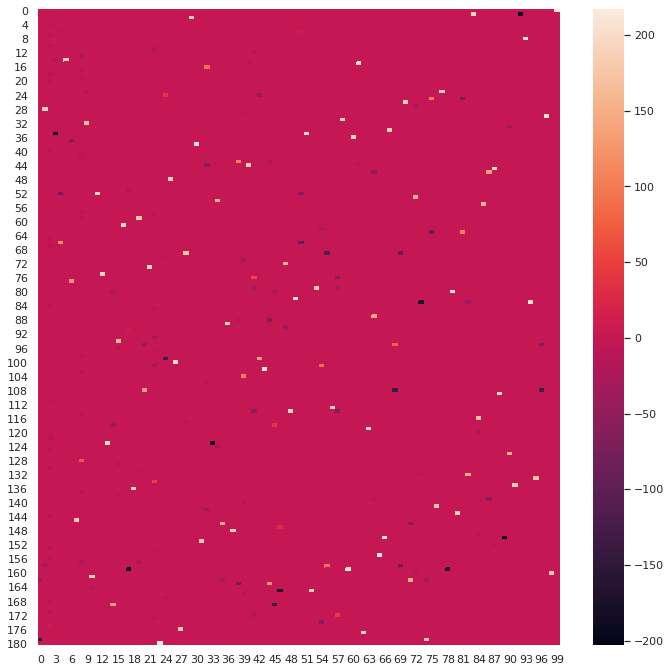

In [ ]:
import seaborn as sns; sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,11.7)})

assign_matrix = matrix
for i, j in zip(row_ind, col_ind):
  assign_matrix[i][j] = -matrix[i][j]
    
ax = sns.heatmap(assign_matrix)

213
213 100 100 100
correct/total: 23848/30188 78.99827746124288%
accuracy: 39.675664577162564
precision: 78.01007335603221
accept rate: 75.0

XY->2
176
176 100 100 100
correct/total: 15169/19727 76.89461144624119%
accuracy: 46.4255758366402
precision: 76.60619750237628
accept rate: 77.0

X_2Y_2
181
181 100 100 100
correct/total: 14509/19727 73.5489430729457%
accuracy: 42.64707860591568
precision: 73.47753513245391
accept rate: 71.0

In [ ]:
"""
Precision: How much percentage of the grouped ids are really from one group
"""

DEBUG = True
walker_ids = set(df_walks_connected['walker_id'].tolist())
correct, total = 0, 0
if DEBUG: print(len(walker_ids))
    
for walker_id in walker_ids:
    id_list = df_walks_connected.loc[df_walks_connected['walker_id'] == walker_id].sort_values('walk_time')['real_id'].tolist()
    dic = collections.Counter(id_list)
    
    l = max(dic.values())
    key = [k for k,v in dic.items() if v == l]
    
    correct += l
    total += sum(dic.values())

# print(f'correct/tried: {correct}/{tried} {correct/tried*100}%') 
print(f'correct/total: {correct}/{total} {correct/total*100}%')

181
correct/total: 15693/19727 79.5508693668576%


In [ ]:
"""
Accuracy: How much percentage of one group is correctly grouped together (only consider the largest sub-group of grouped ids)
"""

DEBUG = False
real_ids = set(df_walks_connected['real_id'].tolist())
correct, total = 0, 0
for real_id in real_ids:
    id_list = df_walks_connected.loc[df_walks_connected['real_id'] == real_id].sort_values('walk_time')['walker_id'].tolist()
    dic = collections.Counter(id_list)
    if DEBUG: print(id_list)
    
    l = max(dic.values())
    key = [k for k,v in dic.items() if v == l]
    
    correct += l
    total += sum([v for v in dic.values()])
#     df_walks_connected = df_walks_connected.replace({'walker_id': {key[0]: real_id}})
# print(f'base: {total - (150 / 10 - 1) * 10}/{total} {(total - (150 / 10 - 1) * 10)/total*100}')
# print(f'correct/tried: {correct}/{tried} {correct/tried*100}%') 
print(f'correct/total: {correct}/{total} {correct/total*100}%')

correct/total: 16694/19727 84.62513306635574%


In [ ]:
DEBUG = False
real_ids = set(df_walks_connected['real_id'].tolist())
correct, total = 0, 0
visited = set()
for real_id in real_ids:
    id_list = df_walks_connected.loc[df_walks_connected['real_id'] == real_id].sort_values('walk_time')['walker_id'].tolist()
    dic = collections.Counter(id_list)
    if DEBUG: print(id_list)
    
    l = max(dic.values())
    p = [v for k,v in dic.items() if v == l][0] / sum(dic.values())
    if p > 0.6:
      correct += 1
    
#     df_walks_connected = df_walks_connected.replace({'walker_id': {key[0]: real_id}})
# print(f'base: {total - (150 / 10 - 1) * 10}/{total} {(total - (150 / 10 - 1) * 10)/total*100}')
# print(f'correct/tried: {correct}/{tried} {correct/tried*100}%') 
print(f'correct/total: {correct}/{len(real_ids)} {correct/len(real_ids)*100}%')

correct/total: 84/100 84.0%


In [ ]:
cnx.execute('DROP TABLE IF EXISTS walks_attached')
df_walks_connected.to_sql('walks_attached', con=cnx)

# Compute Other Info

In [ ]:
id = '1tmp'
path = df_walks_connected.loc[df_walks_connected['walker_id'] == id].sort_values('walk_time')

In [ ]:
for (indx1,row1),(indx2,row2) in zip(path[:-1].iterrows(),path[1:].iterrows()):
    jsondict1, jsondict2 = json.loads(row1['json']), json.loads(row2['json'])
    agent_id1, agent_id2 = pos_to_id[(jsondict1['position']['x'], jsondict1['position']['y'])], 
    pos_to_id[(jsondict2['position']['x'], jsondict2['position']['y'])]
    